# Optimising the Rosenbrock Function

The Rosenbrock function is a classic non-convex optimization problem and a popular benchmark for testing optimization algorithms.

### Rosenbrock Function Formula 📝
The Rosenbrock function is defined as:

$$
f(x) = \sum_{i=1}^{n-1} [100(x_{i+1} - x_i^2)^2 + (1 - x_i)^2]
$$

### Global Minimum 🎯
For $N=3$, the global minimum is at $x = [1, 1, 1]$. 

## Algorithms Exploration 🚀

Starting point: How do different optimization algorithms tackle this problem?

Let us explore three different optimization libraries:
- **PyTorch**: Using its automatic differentiation and optimisation algorithms.
- **Firedrake.adjoint**: Leveraging its automatic differentiation combined with SciPy's optimization algorithms, L-BFGS-B.


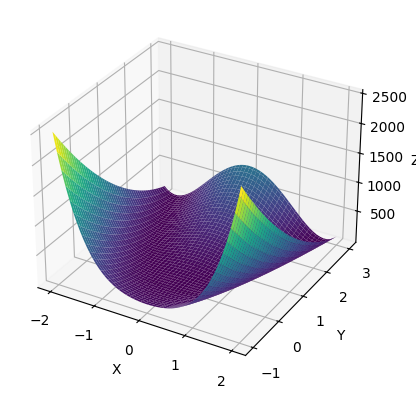

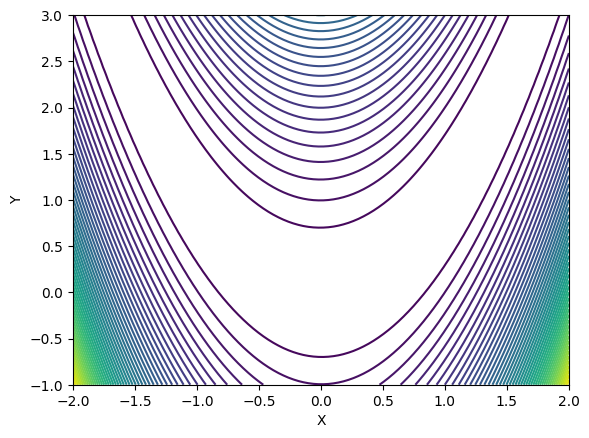

In [27]:
# plot rosenbrock function
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 3, 100)
x, y = np.meshgrid(x, y)
z = (1 - x)**2 + 100*(y - x**2)**2
ax.plot_surface(x, y, z, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# plot contour of rosenbrock function
plt.contour(x, y, z, 50)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [28]:
iterations = 20
number_of_cases = 100
n = 3  # number of dimensions
# produce a list of random numbers in the range (0,1.0]
list_of_random_numbers =[[np.random.rand() for i in range(n)] for j in range(number_of_cases)]

[[0.33923225142608515, 0.48200151293108806, 0.526164701967461], [0.9350958398482738, 0.353099300345604, 0.579349209757835], [0.8144655604591035, 0.25532808877122426, 0.38711480875536974], [0.10373880709520589, 0.5906259139640269, 0.9757420642929879], [0.9492164820908512, 0.4401556920140889, 0.7885019690369806], [0.2873736244075087, 0.11886043738735452, 0.23975031595642537], [0.9631583097275591, 0.9514476925394716, 0.5199281617987055], [0.285776844059039, 0.17715062733187603, 0.7239528172081215], [0.7669022047107781, 0.7153825452626918, 0.11756126555944435], [0.9032257450486059, 0.8028395622707649, 0.2116255930029911], [0.2861203730241195, 0.9330817014545134, 0.1923873717109007], [0.21824206413451286, 0.9199454453198029, 0.6648251528494808], [0.2604515704209518, 0.3645238211255515, 0.1617002990155879], [0.6203278139937719, 0.19266801291002422, 0.19249312359595983], [0.7985535980460171, 0.5553374459482651, 0.5473643376013901], [0.6794196339431973, 0.3501004968382977, 0.17136243980368193]

In [29]:
%time
from functools import partial
import torch
from torch import optim

def rosenbrock(x, n):
    return sum(100*(x[i+1] - x[i]**2)**2 + (1 - x[i])**2 for i in range(len(x)-1))

result_torch = []
for j in range(number_of_cases):
    a = torch.tensor(list_of_random_numbers[j], requires_grad=True)
    loss = partial(rosenbrock, a, n)
    opt = optim.LBFGS([a])
    for i in range(iterations):
        opt.zero_grad()
        loss().backward()
        opt.step(loss)
    result_torch.append(a.tolist())



CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 2.86 µs


Next, I will be exploring the `firedrake.adjoint` module, which combines Firedrake's automatic differentiation capabilities with SciPy's optimization algorithms. The automated adjoint is given by first tape the forward model as a list of blocks that store the operations. Then, the adjoint model is automatically generated by reversing the order of the blocks and applying the chain rule to each block. The adjoint model is then used to compute the gradient of the objective function with respect to the control variables.

In Firedrake, we are solving the forward problem using the rosenbrock function in weak form. We consider the function space $V = \mathbb{R}^N$ and the control variable $x \in V$.

We first import firedrake and firedrake.adjoint. We start to tape the forward model with ``continue_annotation()``.

In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["PETSC_ARCH"] = "minimal_petsc"
os.environ["PETSC_DIR"] = "/Users/ddolci/tes_fire_install/petsc"
from firedrake import *
from firedrake.adjoint import *
continue_annotation()

True

In [ ]:
%time
mesh = UnitSquareMesh(1, 1)
R = FunctionSpace(mesh, "R", 0)
result_firedrake = []
for j in range(number_of_cases):
    x = [Function(R, val=list_of_random_numbers[j][i]) for i in range(n)]
    f = sum(100*(x[i+1] - x[i]**2)**2 + (1 - x[i])**2 for i in range(len(x)-1))
    # cost function
    J = assemble(f * dx(domain=mesh))
    c = [Control(xi) for xi in x]
    rf = ReducedFunctional(J, c)
    result = minimize(rf, method="L-BFGS-B", options={"maxiter": iterations})
    result_firedrake.append([float(result[i]) for i in range(len(result))])
    # Clear the tape.
    get_working_tape().clear_tape()

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs


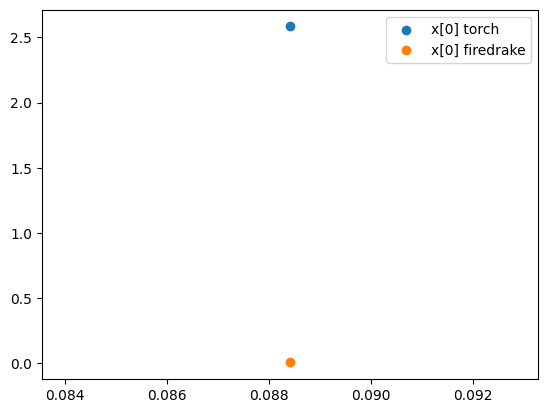

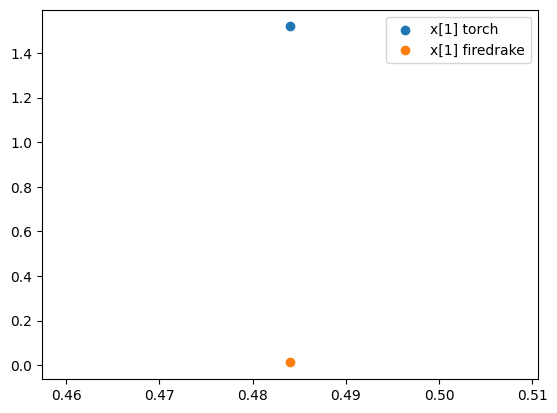

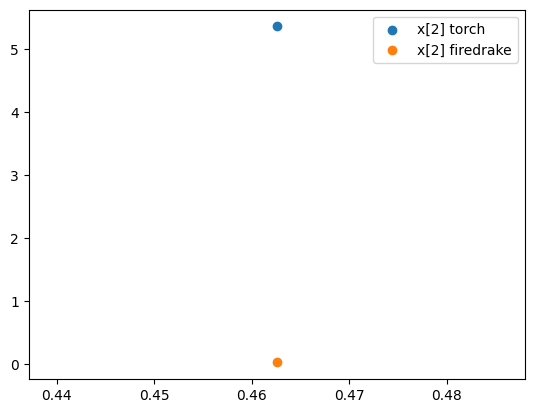

In [ ]:
errors_torch = [
    [abs(result_torch[j][i] - 1.0) for i in range(len(result_torch[j]))] 
    for j in range(number_of_cases)
    ]
errors_firedrake = [
    [abs(result_firedrake[j][i] - 1.0) for i in range(len(result_firedrake[j]))]
    for j in range(number_of_cases)
    ]


for i in range(len(errors_torch[0])):
    plt.scatter(
        [list_of_random_numbers[j][i] for j in range(number_of_cases)],
        [errors_torch[j][i] for j in range(number_of_cases)], label=f'x[{i}] torch'
        )
    plt.scatter(
        [list_of_random_numbers[j][i] for j in range(number_of_cases)],
        [errors_firedrake[j][i] for j in range(number_of_cases)], label=f'x[{i}] firedrake'
        )
    plt.legend(loc='upper right')
    plt.show()